# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Mental-Health-In-Tech-Survey-2016-:-Clustering-Model-Seleciton" data-toc-modified-id="OSMI-Mental-Health-In-Tech-Survey-2016-:-Clustering-Model-Seleciton-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Mental Health In Tech Survey 2016 : Clustering Model Seleciton</a></div><div class="lev1 toc-item"><a href="#Variables-Chosen" data-toc-modified-id="Variables-Chosen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variables Chosen</a></div><div class="lev2 toc-item"><a href="#Usage-of-explanation-variables" data-toc-modified-id="Usage-of-explanation-variables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Usage of explanation variables</a></div><div class="lev1 toc-item"><a href="#Initial-Modeling" data-toc-modified-id="Initial-Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Modeling</a></div><div class="lev1 toc-item"><a href="#Model-Selection" data-toc-modified-id="Model-Selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Selection</a></div>

# OSMI Mental Health In Tech Survey 2016 : Clustering Model Seleciton

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my model selection procedure on a clustering of a set of questions related to employers and how the treat mental health._

In [35]:
#imports
library(poLCA)

#constants
sigLev = 3
percentMul = 100
options(warn=-1) #turns off warnings

In [36]:
clusterFrame = read.csv("../data/processed/clusterDataset.csv")

# Variables Chosen

You can see my [cluster map file](../data/preprocessed/clusterColumnMap.csv) to get a full sense of the variables used in this analysis. In this file, any variable I did not use contains an empty ```newColName```, and any variable that I am considering contains a particular ```newColName```. Because there are around $19$ variables that I am considering in my initial models, it seems to be overkill to list out the entire map here rather than describe them as they become relevant.

## Usage of explanation variables

We see for the questions related to bringing up a mental health or physical health issue in an interview, they have a written explanation section included. While I have chosen to include these in my processed dataset, their usage may be difficult to specify due to the sparsity of user-inputted language. That being said, we may try certain methods on these sections in order to have their language inform our clustering models. In particular, it may be useful to consider a dimensionally reduced form of these questions.

In [37]:
filteredClusterFrame = clusterFrame[,!names(clusterFrame) %in% c(
                                        "explanationMH","explanationPH")]

# Initial Modeling

Because we have only categorical variables, it seems reasonable to limit our analysis to only considering latent class models. This is because we do not need to deal with mixed types, and so a typical $K$-modes clustering algorithm is not entirely necessary.

I have a feeling that there are two main narratives that we need to consider: The narrative of "employers are doing enough for mental health" and the narrative of "employers are not doing enough for mental health." Because of this, I think it might be useful to initially consider a $2$-class model.

In [48]:
#make formula
columnString = paste(colnames(filteredClusterFrame),collapse = ",")
lhs = paste0("cbind(",columnString,")")
givenForm = paste0(lhs,"~1")
print(givenForm)
initMod.lcm = poLCA(cbind(empPrimTech,empProvideMHB,knowMHB,empDiscMH,empResourceMH,anonProtected,askLeaveDiff,negConsDiscMH,negConsDiscPH,coworkComfMHD,superComfMHD,empSeriousMH,heardNegConsMH,discInterviewPH,discInterviewMH,hurtCareerMH,teamNegMH,observeBadResponseMH,revealLikelihoodMH)~1,
                    data = filteredClusterFrame,nclass = 2,verbose = FALSE)

[1] "cbind(empPrimTech,empProvideMHB,knowMHB,empDiscMH,empResourceMH,anonProtected,askLeaveDiff,negConsDiscMH,negConsDiscPH,coworkComfMHD,superComfMHD,empSeriousMH,heardNegConsMH,discInterviewPH,discInterviewMH,hurtCareerMH,teamNegMH,observeBadResponseMH,revealLikelihoodMH)~1"


In [84]:
help(poLCA)

In [78]:
a = initMod.lcm$probs[["empPrimTech"]]
classOne = a["class 1: ",]
classTwo = a["class 2: ",]
klDiv = sum(classOne * log2(classOne / classTwo))

In [82]:
#make kldiv function for a given varname
getKLDiv = function(varName){
    #helper for getting the KL-Divergence for a given variable
    varCondDist = initMod.lcm$probs[[varName]]
    classOne = varCondDist["class 1: ",]
    classTwo = varCondDist["class 2: ",]
    klDiv = sum(classOne * log2(classOne / classTwo))
    return(klDiv)
}
#make kl divergence vector
klDivVec = sapply(colnames(filteredClusterFrame),getKLDiv)
#order by value
givenOrder = order(klDivVec)
klDivVec = klDivVec[givenOrder]
klDivVec = signif(klDivVec,sigLev)
klDivVec

empPrimTech              knowMHB        empProvideMHB 
             0.00872              0.04290              0.04890 
      heardNegConsMH        empResourceMH      discInterviewPH 
             0.08590              0.09740              0.15700 
       anonProtected            empDiscMH observeBadResponseMH 
             0.19000              0.20200              0.29000 
  revealLikelihoodMH        negConsDiscPH      discInterviewMH 
             0.41100              0.53600              0.55500 
        empSeriousMH        coworkComfMHD         askLeaveDiff 
             0.91900              1.01000              1.16000 
           teamNegMH         superComfMHD        negConsDiscMH 
             1.21000              1.53000              2.62000 
        hurtCareerMH 
            26.70000

_Table 1: Variables by KL-Divergence between the two class distribution for each variable in our latent class model._

We see among the key important support variables such as whether the employer provides mental health benefits (```empProvideMHB```), whether the employer offers resources to deal with mental health (```empResourceMH```), and whether an individual knows about their mental health benefits (```knowMHB```), our KL-divergence is quite low. This might suggest that we would need to consider more classes if we want to discover meaningful separations in these variables.

[1] "The number in our uncertainty range is 22"


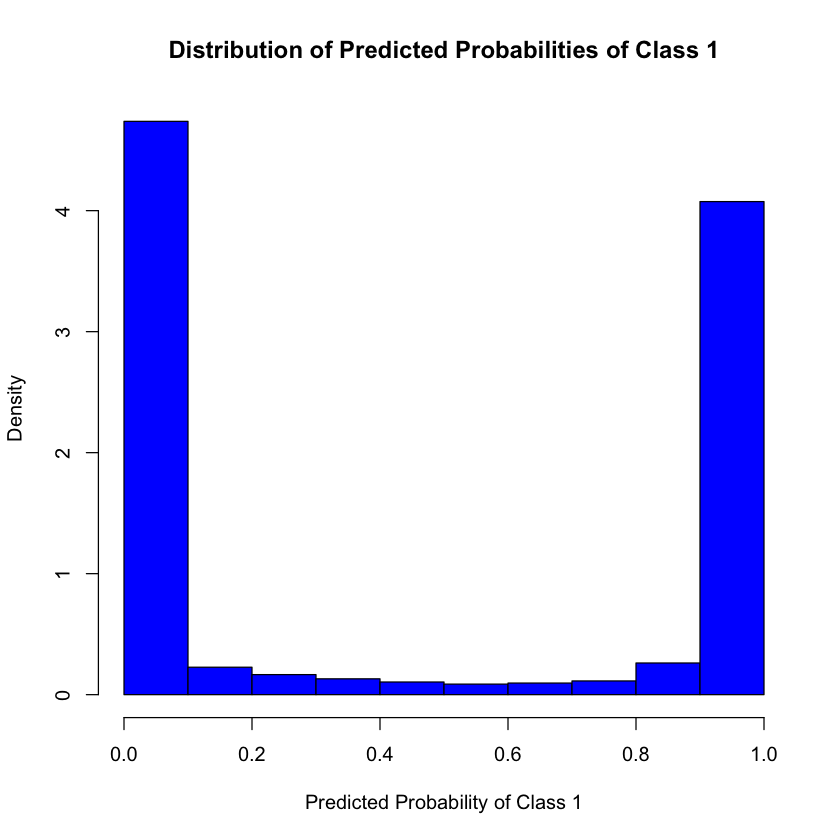

In [92]:
#get distribution of is class 1
classOnePredictions = initMod.lcm$posterior[,1]
hist(classOnePredictions,col = "Blue",freq = FALSE,
     xlab = "Predicted Probability of Class 1",
     main = "Distribution of Predicted Probabilities of Class 1")
numUncertain = sum(classOnePredictions > .4 & classOnePredictions < .6)
print(paste("The number in our uncertainty range is",numUncertain))

_Figure 1: Distribution of predicted probabilities._

We see that our model is currently quite certain about it's predictions, Since we only have around $22$ of our $>1000$ observations in the uncertainty range of $0.4$ and $0.6$.

# Model Selection

**DESCRIBE MORE HERE**

In [102]:
inferenceRows = sample(1:dim(filteredClusterFrame)[1],
                       round(dim(filteredClusterFrame)[1] / 2))

In [112]:
inferenceSet = filteredClusterFrame[inferenceRows,]
selectionSet = filteredClusterFrame[-inferenceRows,]
print(initMod.lcm$predcell)
help(poLCA.posterior)

     empPrimTech empProvideMHB knowMHB empDiscMH empResourceMH anonProtected
1              1             1       1         1             1             1
2              1             1       1         1             1             1
3              1             1       1         1             1             1
4              1             1       1         1             1             1
5              1             1       1         1             1             1
6              1             1       1         1             1             1
7              1             1       1         1             1             1
8              1             1       1         1             1             1
9              1             1       1         1             1             1
10             1             1       1         1             1             1
11             1             1       1         1             1             1
12             1             1       1         1             1             1

In [137]:
probOfObsGivenClass = function(lcmMod,obs,classNum){
    #gets the probability of an observation given a particular class
    prob = 1 #will multiply upon this
    className = paste0("class ",classNum,": ")
    for (colName in names(obs)){ #calculate probability
        if (colName != "fold"){
        #get variable level string
            varLev = obs[colName]
            varString = paste0("Pr(",varLev,")")
            varMat = lcmMod$probs[[colName]]
            givenProb = varMat[className,varString]
            prob = prob * givenProb
        }
    }
    return(prob)
}
probOfObs = function(lcmMod,obs){
    #helper that predicts the probability of seeing an observation in
    probOfObs = 0
    for (classNum in 1:length(lcmMod$P)){
        #get probability of observation given class
        probGivenClass = probOfObsGivenClass(lcmMod,obs,classNum)
        probGivenClassMul = probGivenClass * lcmMod$P[classNum]
        probOfObs = probOfObs + probGivenClassMul
    }
    return(probOfObs)
}
getLogLike = function(lcm,givenFrame){
    #helper that gets the log-likelihood of a dataset given a particular latent
    #class model
    predictedProbs = apply(givenFrame,1,probOfObs,lcmMod = lcm)
    logLikelihood = sum(log(predictedProbs))
    return(logLikelihood)
}

In [ ]:
#cv functions
form = cbind(empPrimTech,empProvideMHB,knowMHB,empDiscMH,empResourceMH,
             anonProtected,askLeaveDiff,negConsDiscMH,negConsDiscPH,
             coworkComfMHD,superComfMHD,empSeriousMH,heardNegConsMH,
             discInterviewPH,discInterviewMH,hurtCareerMH,teamNegMH,
             observeBadResponseMH,revealLikelihoodMH)~1
getLogLikeCV <- function(numClasses,givenFrame,numFolds = 5){
    #helper for getting cross-validated log-likelihood a dataset given a
    #particular latent class model
    #make folds
    givenFrame$fold = sample(1:numFolds,dim(givenFrame)[1],replace = TRUE)
    cvVec = rep(0,numFolds)
    #then run through folds
    for (foldLev in 1:numFolds){
        #make cv slit
        trainSet = givenFrame[which(givenFrame$fold != foldLev),]
        testSet = givenFrame[which(givenFrame$fold == foldLev),]
        #train on trainSet
        newMod.lcm = poLCA(form,data = trainSet,nclass = numClasses,
                           verbose = FALSE)
        #get log-likelihood on test set
        cvVec[foldLev] = getLogLike(newMod.lcm,testSet)
    }
    return(mean(cvVec))
}
#then try to get cv vec
numClassesConsidered = 10
consideredClassSizes = 1:numClassesConsidered
cvVec = rep(0,numClassesConsidered)
for (lev in consideredClassSizes){
    cvVec[lev] = getLogLikeCV(lev,selectionSet)
}

In [141]:
print(cvVec)

 [1] -2327.423 -2218.328 -2169.989      -Inf -2460.318      -Inf      -Inf
 [8] -2909.640      -Inf      -Inf
